<a href="https://colab.research.google.com/github/aiswarya-1422/ictak/blob/main/Xai_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.856651517012652
              precision    recall  f1-score   support

           0     0.8884    0.9277    0.9076      6181
           1     0.7350    0.6327    0.6800      1960

    accuracy                         0.8567      8141
   macro avg     0.8117    0.7802    0.7938      8141
weighted avg     0.8515    0.8567    0.8528      8141



100%|===================| 1999/2000 [03:27<00:00]       

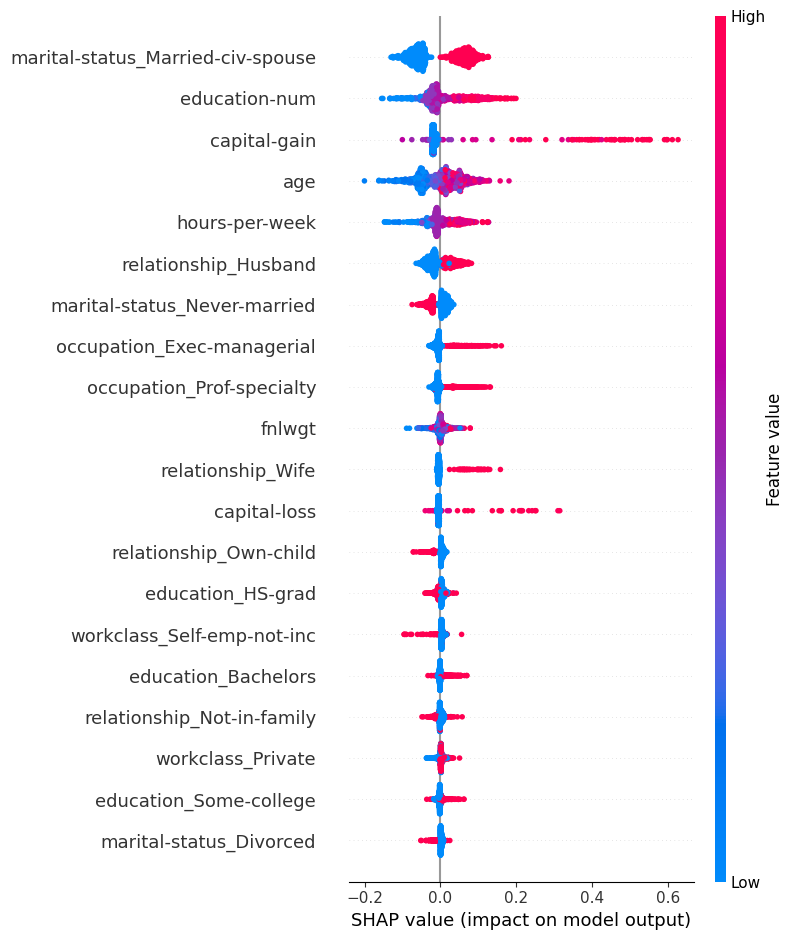

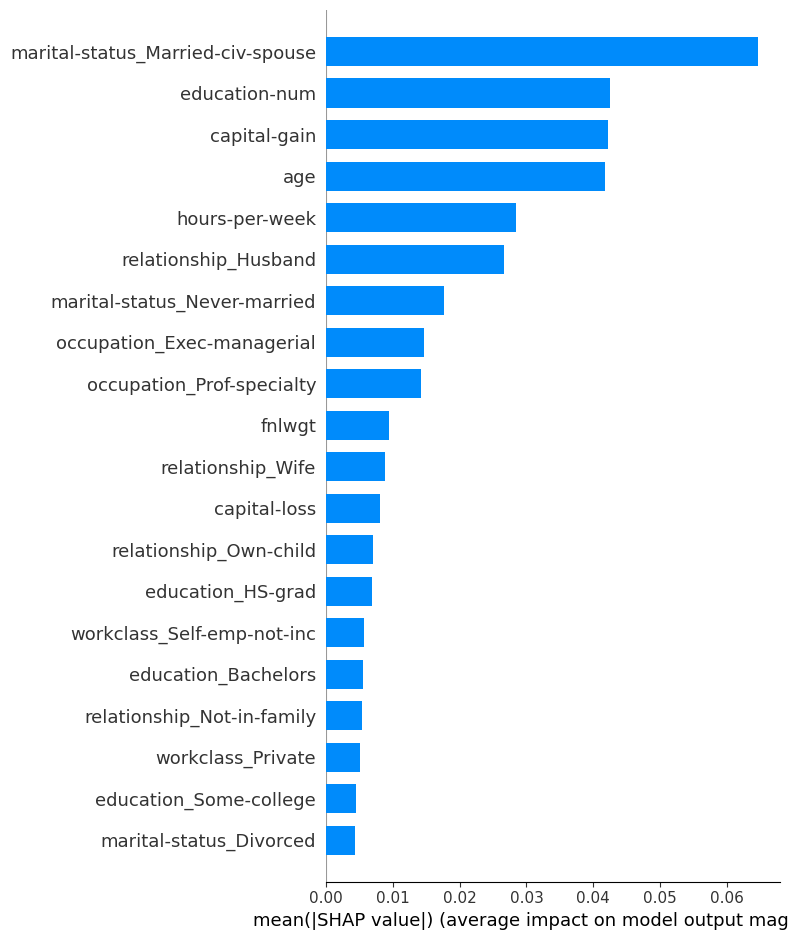


Top 10 features by mean(|SHAP|):
 marital-status_Married-civ-spouse    0.064679
education-num                        0.042484
capital-gain                         0.042241
age                                  0.041746
hours-per-week                       0.028442
relationship_Husband                 0.026635
marital-status_Never-married         0.017659
occupation_Exec-managerial           0.014610
occupation_Prof-specialty            0.014292
fnlwgt                               0.009381
dtype: float64


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.pyplot as plt
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
        "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

df = pd.read_csv(url, header=None, names=cols, na_values=" ?", skipinitialspace=True)

# 2. Clean data
df = df.drop(columns=["race","sex"])
df = df.dropna()
df["income"] = df["income"].apply(lambda s: 1 if s.strip() == ">50K" else 0)

# 3. Features and label
X = df.drop(columns=["income"])
y = df["income"]

# One-hot encode categorical variables
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_ohe = pd.DataFrame(
    ohe.fit_transform(X[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X.index
)
X_prepared = pd.concat(
    [X[num_cols].reset_index(drop=True), X_ohe.reset_index(drop=True)],
    axis=1
)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.25, random_state=42, stratify=y
)

# 5. Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 6. Evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 7. SHAP Analysis
sample_idx = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_sample = X_test.iloc[sample_idx]

explainer = shap.Explainer(rf, X_train)   # model + background
shap_values = explainer(X_test_sample)    # shap.Explanation object

shap_class1 = shap_values[:, :, 1]

# Beeswarm plot
shap.summary_plot(shap_class1, features=X_test_sample)

# Bar plot (global importance)
shap.summary_plot(shap_class1, features=X_test_sample, plot_type="bar")

# 8. Top features by mean(|SHAP|)
mean_abs_shap = np.abs(shap_class1.values).mean(axis=0)
feat_imp = pd.Series(mean_abs_shap, index=X_test_sample.columns).sort_values(ascending=False)
print("\nTop 10 features by mean(|SHAP|):\n", feat_imp.head(10))
